In [1]:
import numpy as np
import scipy
from scipy.stats import ncx2
from scipy.special import hyp1f1
from scipy.optimize import brentq
from math import exp
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import kurtosis

DECIMALS = 6

np.set_printoptions(precision=DECIMALS, suppress=True)
pd.options.display.float_format = lambda x: f"{x:.{DECIMALS}f}"
pd.set_option("display.precision", DECIMALS)

In [50]:
loan_types = ["bullet", "linear", "french", "negative"]

def bullet_exposure(contract, T, t):
    P = float(contract["P"])
    return P if t < T else 0.0


def linear_exposure(contract, T, t):
    P = float(contract["P"])
    periods_per_year = float(contract["N"])
    if periods_per_year <= 0 or T <= 0:
        return 0.0

    period = 1.0 / periods_per_year  # years per period
    total_periods = int(np.ceil(T * periods_per_year))
    payments_made = int(np.floor(t / period))
    payments_made = int(np.clip(payments_made, 0, total_periods))
    principal_paid = (payments_made / total_periods) * P
    return max(P - principal_paid, 0.0)


def french_exposure(contract, T, t):
    P = float(contract["P"])
    periods_per_year = float(contract["N"])
    r_annual = float(contract["r"])
    if periods_per_year <= 0 or T <= 0:
        return 0.0

    period = 1.0 / periods_per_year  # years per period
    total_periods = int(np.ceil(T * periods_per_year))
    payments_made = int(np.floor(t / period))
    payments_made = int(np.clip(payments_made, 0, total_periods))
    periods_remaining = total_periods - payments_made
    if periods_remaining <= 0:
        return 0.0

    r_period = r_annual / periods_per_year  # annual to per-period rate

    if r_period == 0.0:
        payment = P / total_periods
        return payment * periods_remaining

    annuity_payment = P * r_period / (1.0 - (1.0 + r_period) ** (-total_periods))
    pv_remaining = annuity_payment * (1.0 - (1.0 + r_period) ** (-periods_remaining)) / r_period
    return pv_remaining


def negative_amortization_exposure(contract, T, t):
    P = float(contract["P"])
    periods_per_year = float(contract["N"])
    r_annual = float(contract.get("r", 0.0))
    if periods_per_year <= 0 or T <= 0:
        return max(P, 0.0)

    period = 1.0 / periods_per_year  # years per period
    total_periods = int(np.ceil(T * periods_per_year))
    periods_elapsed = int(np.floor(t / period))
    periods_elapsed = int(np.clip(periods_elapsed, 0, total_periods))

    r_period = r_annual / periods_per_year  # annual to per-period rate

    exposure = P * ((1.0 + r_period) ** periods_elapsed)

    return exposure if t < T else 0.0


def exposure_at_time(contract, T, t):
    loan_type = str(contract["type"]).lower()
    dispatch = {
        "bullet": bullet_exposure,
        "linear": linear_exposure,
        "french": french_exposure,
        "negative": negative_amortization_exposure,
    }
    if loan_type not in dispatch:
        raise ValueError(f"Unknown loan type: {loan_type}")
    return dispatch[loan_type](contract, T, t)


In [51]:
T = 1.0

def plot_ead_profiles(contracts, T):
    plt.figure(figsize=(12, 8))
    for idx, contract in contracts.iterrows():
        times = np.linspace(0, T, num=1000)
        exposures = [exposure_at_time(contract, T, t) for t in times]
        plt.plot(times, exposures, label=f"Contract {idx} ({contract['type']})")
    plt.title("EAD Profiles Over Time")
    plt.xlabel("Time (years)")
    plt.ylabel("Exposure at Default (EAD)")
    plt.legend()
    plt.grid()
    plt.show()

In [52]:
bullet = {
    "type": "bullet",
    "P": 10.0,
    "N": 12,
    "r": 0.20,
}

linear = {
    "type": "linear",
    "P": 10.0,
    "N": 12,
    "r": 0.20,
}

french = {
    "type": "french",
    "P": 10.0,
    "N": 12,
    "r": 0.20,
}

neg = {
    "type": "negative",
    "P": 10.0,
    "N": 12,
    "r": 0.10
}

base_contracts = pd.DataFrame([bullet, linear, french, neg])
base_contracts

,type,P,N,r
0,bullet,10.000000,12,0.200000
1,linear,10.000000,12,0.200000
2,french,10.000000,12,0.200000
3,negative,10.000000,12,0.100000


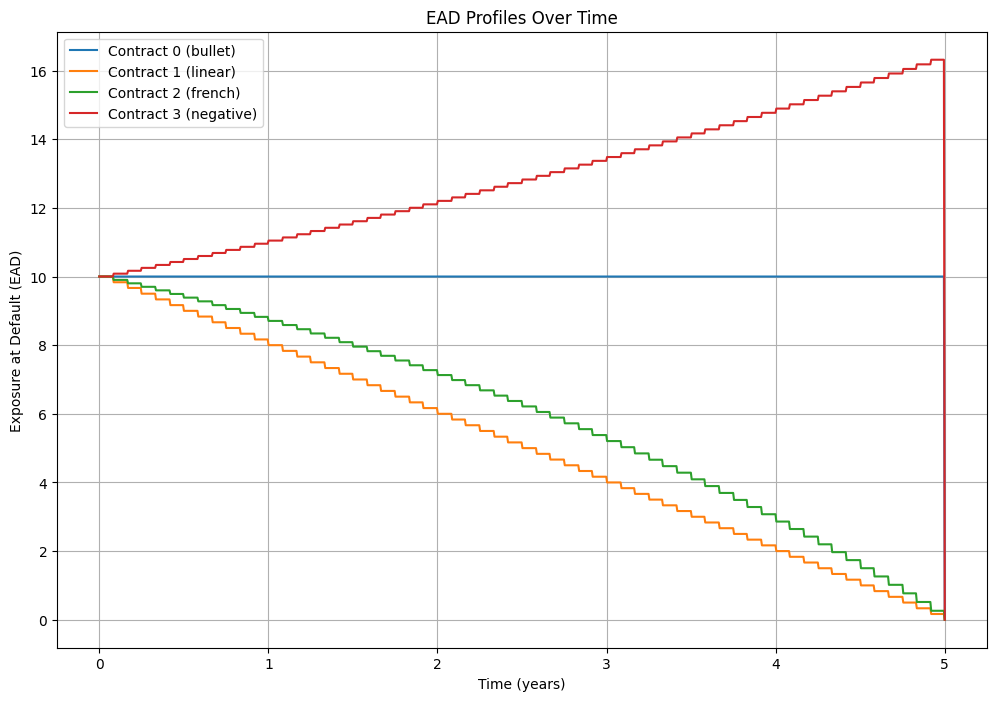

In [53]:
plot_ead_profiles(base_contracts, T=5.0)

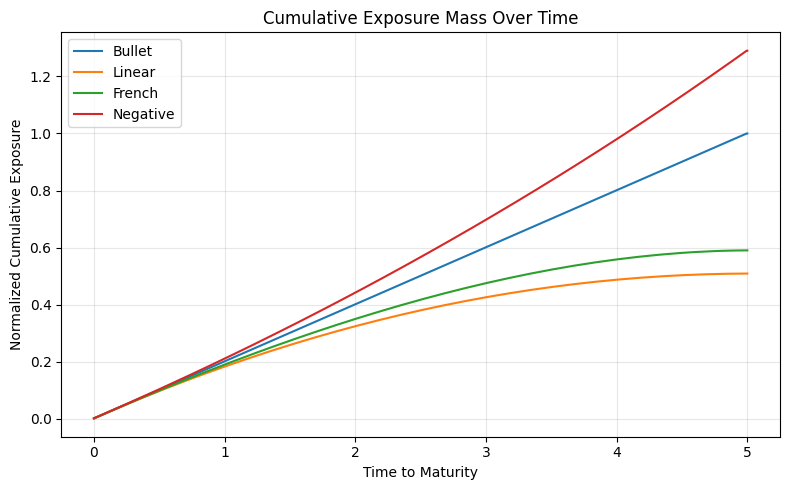

In [54]:
def plot_cumulative_exposure_mass(contracts, T, num_points=1000):
    plt.figure(figsize=(8, 5))

    times = np.linspace(0, T, num=num_points)
    dt = times[1] - times[0]

    for idx, contract in contracts.iterrows():
        P = contract["P"]
        exposures = np.array([exposure_at_time(contract, T, t) for t in times])
        cumulative_mass = np.cumsum(exposures) * dt
        plt.plot(times, cumulative_mass / (P * T), label=f"{contract['type'].capitalize()}")

    plt.xlabel("Time to Maturity")
    plt.ylabel("Normalized Cumulative Exposure")
    plt.title("Cumulative Exposure Mass Over Time")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_cumulative_exposure_mass(base_contracts, T=5.0)

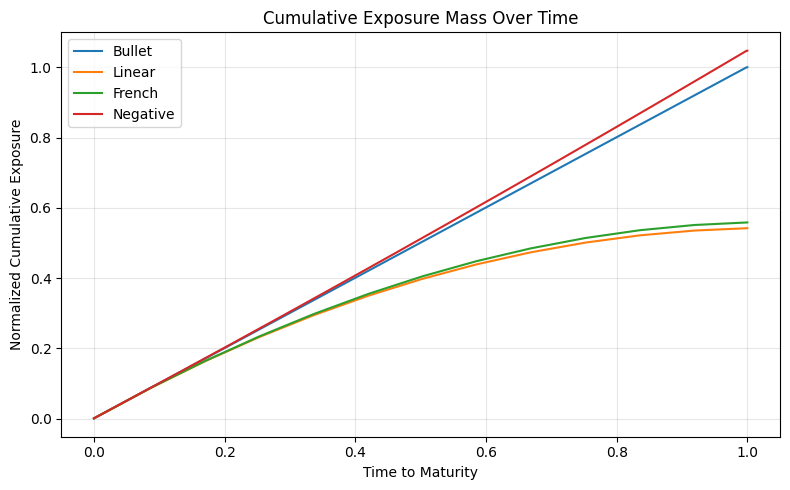

In [55]:
plot_cumulative_exposure_mass(base_contracts, T=1.0)

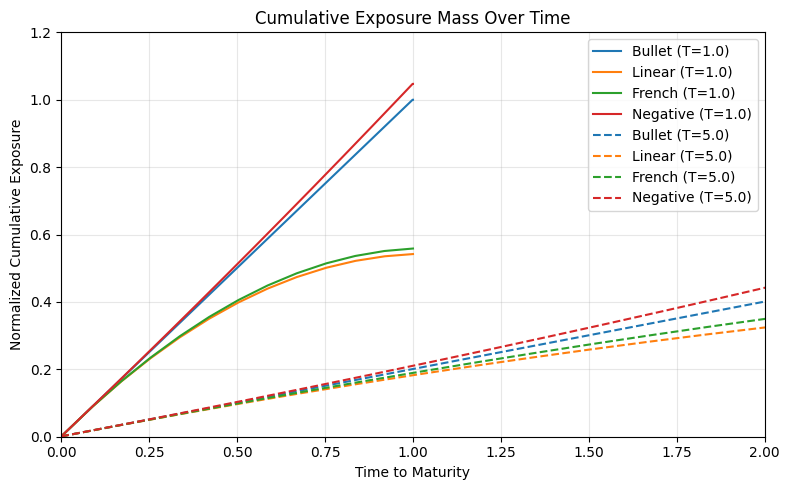

In [63]:
# overlay cumulative exposure of contracts for different times to maturity
Ts = [1.0, 5.0]
linestyles = ["-", "--", ":"]

plt.figure(figsize=(8, 5))

for T_val, ls in zip(Ts, linestyles):
    times = np.linspace(0, T_val, num=1000)
    
    # Define colors for each contract type
    colors = ['C0', 'C1', 'C2', 'C3']  # Default matplotlib color cycle
    dt = times[1] - times[0]
    for idx, contract in base_contracts.iterrows():
        P = contract["P"]
        exposures = np.array([exposure_at_time(contract, T_val, t) for t in times])
        cumulative_mass = np.cumsum(exposures) * dt
        plt.plot(
            times,
            cumulative_mass / (P * T_val),
            linestyle=ls,
            color=colors[idx],
            label=f"{contract['type'].capitalize()} (T={T_val})",
        )

plt.xlabel("Time to Maturity")
plt.xlim(0,2)
plt.ylabel("Normalized Cumulative Exposure")
plt.title("Cumulative Exposure Mass Over Time")
plt.ylim(0,1.2)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
